In [2]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

In [3]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [4]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 1,  7,  4,  6, 10,  2,  9,  3,  5]), tensor([8, 0]))

In [5]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [6]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) # <1>
linear_model(t_un_val)

tensor([[4.2696],
        [3.2116]], grad_fn=<AddmmBackward0>)

In [7]:
linear_model.weight

Parameter containing:
tensor([[0.8331]], requires_grad=True)

In [11]:
linear_model.bias

Parameter containing:
tensor([0.2374], requires_grad=True)

In [13]:
x = torch.ones(1)
linear_model(x)

tensor([1.0705], grad_fn=<AddBackward0>)

In [14]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[1.0705],
        [1.0705],
        [1.0705],
        [1.0705],
        [1.0705],
        [1.0705],
        [1.0705],
        [1.0705],
        [1.0705],
        [1.0705]], grad_fn=<AddmmBackward0>)

In [15]:
linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(
    linear_model.parameters(), # <2>
    lr=1e-2)

In [16]:
linear_model.parameters()

<generator object Module.parameters at 0x7efd8901add0>

In [17]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.0165]], requires_grad=True),
 Parameter containing:
 tensor([-0.4817], requires_grad=True)]

In [18]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


In [19]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 233.2613, Validation loss 20.5655
Epoch 1000, Training loss 3.0519, Validation loss 12.2319
Epoch 2000, Training loss 2.3325, Validation loss 8.1144
Epoch 3000, Training loss 2.3088, Validation loss 7.4819

Parameter containing:
tensor([[5.1940]], requires_grad=True)
Parameter containing:
tensor([-15.9109], requires_grad=True)


In [20]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # <1>
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 326.2464, Validation loss 43.9979
Epoch 1000, Training loss 3.0296, Validation loss 12.1462
Epoch 2000, Training loss 2.3318, Validation loss 8.1024
Epoch 3000, Training loss 2.3088, Validation loss 7.4799

Parameter containing:
tensor([[5.1942]], requires_grad=True)
Parameter containing:
tensor([-15.9124], requires_grad=True)


In [21]:
seq_model = nn.Sequential(
            nn.Linear(1, 13), # <1>
            nn.Tanh(),
            nn.Linear(13, 1)) # <2>
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [22]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [23]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [24]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [25]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [26]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.3484], requires_grad=True)

In [27]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 212.8540, Validation loss 15.3039
Epoch 1000, Training loss 5.3753, Validation loss 7.5701
Epoch 2000, Training loss 6.6530, Validation loss 11.8903
Epoch 3000, Training loss 3.3518, Validation loss 7.5266
Epoch 4000, Training loss 2.0320, Validation loss 6.1225
Epoch 5000, Training loss 1.6001, Validation loss 6.0900
output tensor([[7.8430],
        [2.8268]], grad_fn=<AddmmBackward0>)
answer tensor([[6.0000],
        [0.5000]])
hidden tensor([[  0.5402],
        [ 12.0029],
        [ -0.6792],
        [-12.9589],
        [ 12.5350],
        [  0.5358],
        [  0.3437],
        [-12.6888]])


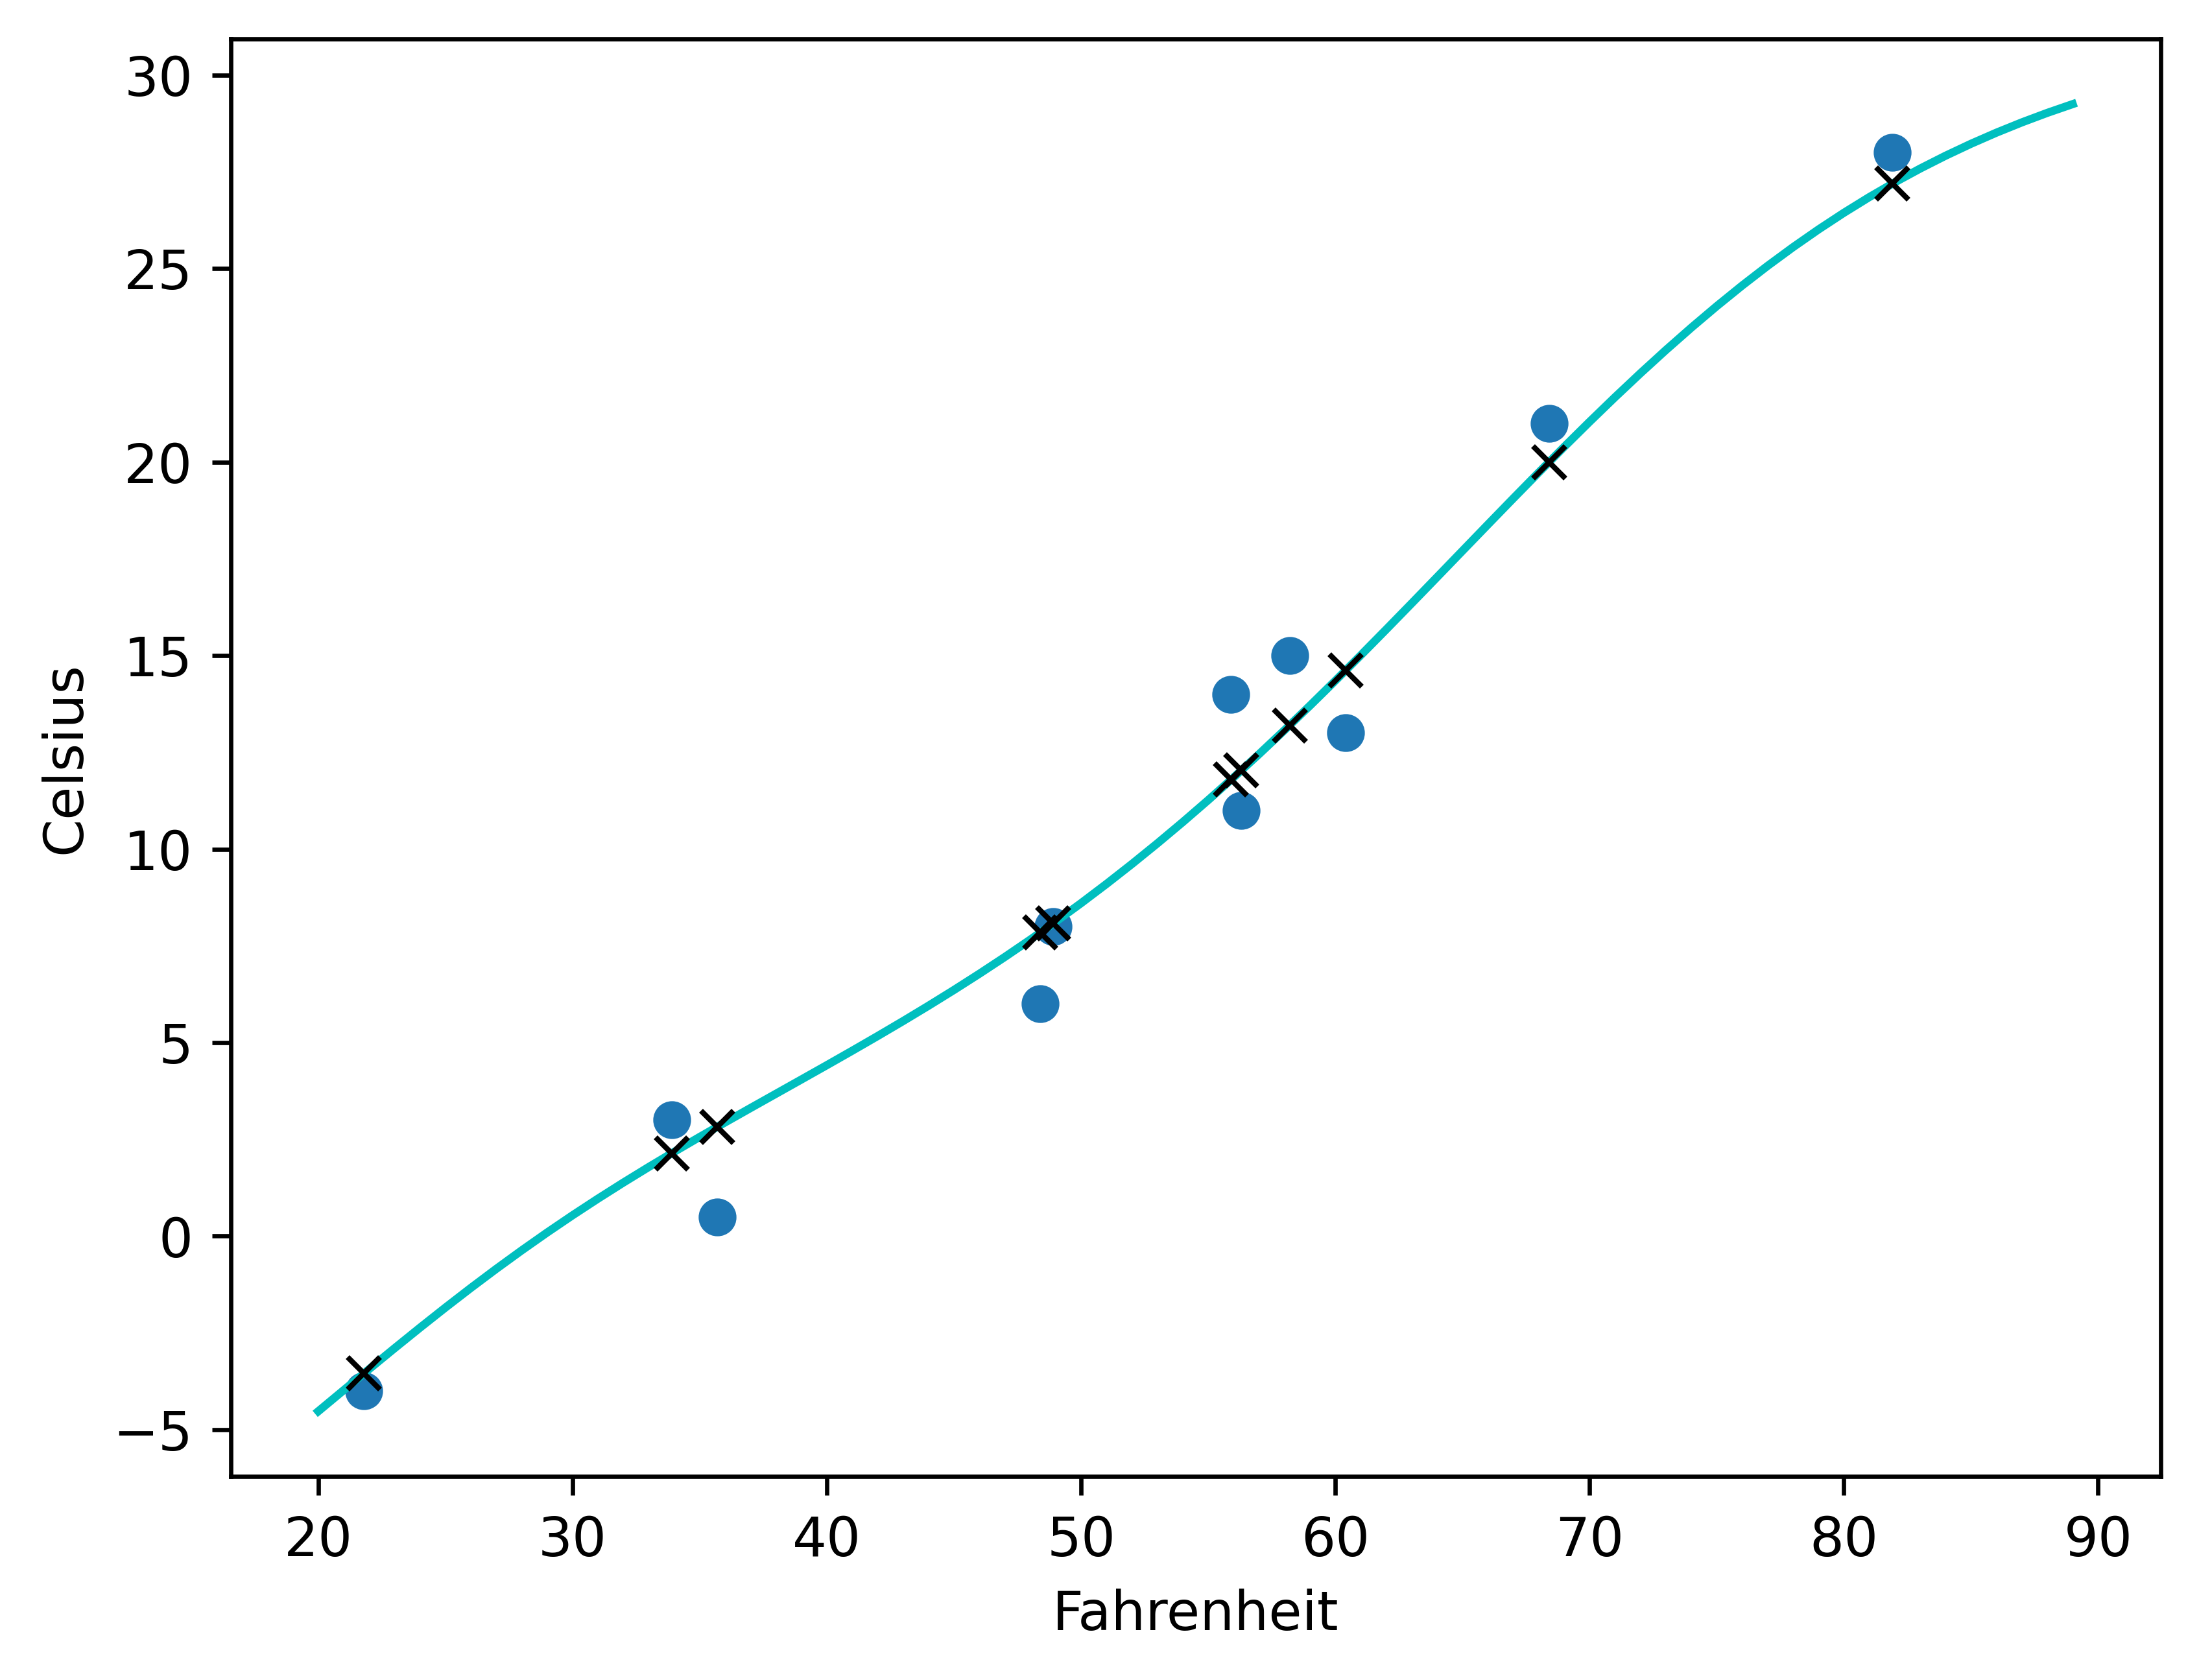

In [28]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')


Epoch 1, Training loss 225.6135, Validation loss 18.3333
Epoch 1000, Training loss 2.9910, Validation loss 5.6054
Epoch 2000, Training loss 3.3715, Validation loss 8.8891
Epoch 3000, Training loss 2.4587, Validation loss 6.8700
Epoch 4000, Training loss 2.0819, Validation loss 6.0860
Epoch 5000, Training loss 1.9245, Validation loss 5.9105


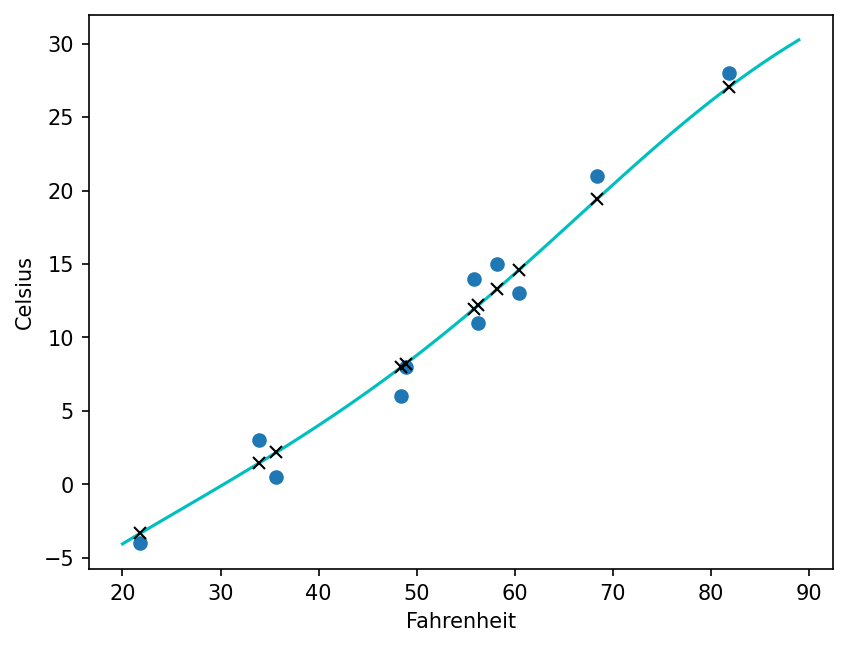

In [48]:
# Exercises here!

neuron_count = 30

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, neuron_count)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(neuron_count, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
